IMPORTS

In [1]:
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np
from sklearn.model_selection import train_test_split, TunedThresholdClassifierCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn import set_config
import os
import pandas as pd

LOAD

In [2]:
# Download latest version
path = kagglehub.dataset_download("advaithsrao/enron-fraud-email-dataset")
print("Path to dataset files:", path)
dataset= os.listdir(path)
full_path= os.path.join(path, dataset[0])
print(full_path)
data= pd.read_csv(full_path)
data.head()

Path to dataset files: C:\Users\KIIT0001\.cache\kagglehub\datasets\advaithsrao\enron-fraud-email-dataset\versions\1
C:\Users\KIIT0001\.cache\kagglehub\datasets\advaithsrao\enron-fraud-email-dataset\versions\1\enron_data_fraud_labeled.csv


C:\Users\KIIT0001\AppData\Local\Temp\ipykernel_12772\4113408355.py:7: DtypeWarning: Columns (7,13) have mixed types. Specify dtype option on import or set low_memory=False.
  data= pd.read_csv(full_path)


,Folder-User,Folder-Name,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,...,Re,Source,Mail-ID,POI-Present,Suspicious-Folders,Sender-Type,Unique-Mails-From-Sender,Low-Comm,Contains-Reply-Forwards,Label
0,maildir,arnold-j,<17334447.1075857585446.JavaMail.evans@thyme>,"Thu, 16 Nov 2000 09:30:00 -0800 (PST)",msagel@home.com,jarnold@enron.com,Status,1.0,text/plain; charset=ANSI_X3.4-1968,7bit,...,,Enron Data,b399fa1ba5ec06ccf8ead1049a53be981d0ebb39ee2c94...,False,False,External,18.0,False,False,0
1,maildir,arnold-j,<19171686.1075857585034.JavaMail.evans@thyme>,"Fri, 8 Dec 2000 05:05:00 -0800 (PST)",slafontaine@globalp.com,john.arnold@enron.com,re:summer inverses,1.0,text/plain; charset=us-ascii,7bit,...,,Enron Data,84b07d7a0a17b545896f670f92d200e86843c2796147d9...,False,False,External,4.0,True,False,0
2,maildir,arnold-j,<29887033.1075857630725.JavaMail.evans@thyme>,"Tue, 15 May 2001 09:43:00 -0700 (PDT)",iceoperations@intcx.com,"icehelpdesk@intcx.com, internalmarketing@intcx...",The WTI Bullet swap contracts,1.0,text/plain; charset=us-ascii,7bit,...,,Enron Data,f7482dd06262f46d341e733aa0c2fb55cb1e257ea153d0...,False,False,External,3.0,True,False,0
3,maildir,arnold-j,<2526360.1075857584903.JavaMail.evans@thyme>,"Mon, 11 Dec 2000 23:52:00 -0800 (PST)",klarnold@flash.net,john.arnold@enron.com,Fwd: NYTimes.com Article: Suspended Rabbi Quit...,1.0,text/plain; charset=us-ascii,7bit,...,,Enron Data,25441e5a837fefda50527731fdbcdf0848663be82cd1ce...,False,False,External,9.0,False,True,0
4,maildir,arnold-j,<30102065.1075857630952.JavaMail.evans@thyme>,"Mon, 14 May 2001 23:59:00 -0700 (PDT)",soblander@carrfut.com,soblander@carrfut.com,daily charts and matrices as hot links 5/15,1.0,text/plain; charset=us-ascii,7bit,...,,Enron Data,c2995c6a70b953ee66c21d8a509ebfbfaca28277917beb...,False,False,External,352.0,False,False,0


In [3]:
print(data.describe())
print('---------------------------------------------------------')
print(f"ROWS: {data.shape[0]}, COLUMNS: {data.shape[1]}")
print('---------------------------------------------------------')
print(f"Labels-\n Ham: {data['Label'].unique()[0]}\n Spam: {data['Label'].unique()[1]} ")
print('---------------------------------------------------------')
print(f"Null value columns:\n{[col for col in data.columns if data[col].isnull().values.any()]}")
print('---------------------------------------------------------')
print(data.dtypes)

       Unique-Mails-From-Sender          Label
count             447417.000000  447417.000000
mean                 979.691999       0.005201
std                 1446.968908       0.071930
min                    0.000000       0.000000
25%                   33.000000       0.000000
50%                  250.000000       0.000000
75%                 1341.000000       0.000000
max                 5486.000000       1.000000
---------------------------------------------------------
ROWS: 447417, COLUMNS: 32
---------------------------------------------------------
Labels-
 Ham: 0
 Spam: 1 
---------------------------------------------------------
Null value columns:
['Subject', 'X-To', 'X-cc', 'X-bcc', 'X-FileName']
---------------------------------------------------------
Folder-User                   object
Folder-Name                   object
Message-ID                    object
Date                          object
From                          object
To                            object


Grouping same data type columns into one list.

In [4]:
obj_col= [col for col in data.columns if data[col].dtypes=='object']
num_col= [col for col in data.columns if data[col].dtypes=='int64' or data[col].dtypes=='float64']
bool_col= [col for col in data.columns if data[col].dtypes=='bool']


In [5]:
data_copy= data.copy()
data_copy['Sender-Type']= data_copy['Sender-Type'].map({'Internal': 1, 'External': 0}).astype(int)
data_copy.drop(columns= ['Mime-Version', 'Content-Transfer-Encoding', 'Mail-ID', 'Folder-User','Folder-Name','From', 
                         'To','Suspicious-Folders', 'Date', 'Message-ID','Content-Type','X-From',
                        'X-To', 'X-cc', 'X-bcc', 'X-Origin', 'X-Folder',  'Cc', 'Attendees',
                       'Bcc', 'Time', 'X-FileName', 'Re', 'Source', 'POI-Present', 'Suspicious-Folders', 'Low-Comm',
                    'Contains-Reply-Forwards', 'Sender-Type', 'Unique-Mails-From-Sender'], axis= 1, inplace= True)


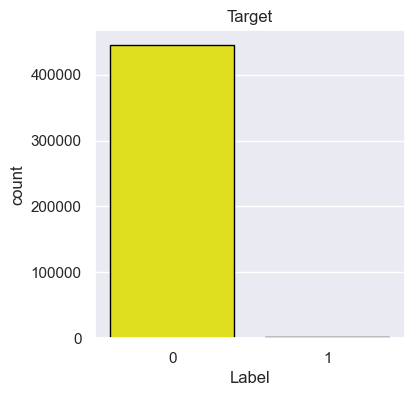

In [6]:
plt.figure(figsize= (4,4))
sns.countplot(x= 'Label', data= data_copy, color= 'yellow', edgecolor= 'black')
plt.title('Target')
plt.show()

In [7]:
print(data_copy['Subject'].isnull().sum())

18020


In [8]:
ham_emails_count= int(data_copy.groupby('Label').describe().iloc[0,0])
spam_emails_count= int(data_copy.groupby('Label').describe().iloc[1,0])
total_count= ham_emails_count+spam_emails_count
print(f"Total count of Ham emails: {ham_emails_count}\nTotal count of Spam emails: {spam_emails_count}")
print('---------------------------------------------------------')
print(f"Proportion of Ham emails: {round(ham_emails_count/total_count *100, 2)}%\nProportion of Spam emails: {round(spam_emails_count/total_count *100, 2)}%")
print('---------------------------------------------------------')
print(f"Count of NULL valued Subject in Ham emails: {int(data[data['Subject'].isnull()].groupby('Label').describe().iloc[0,0])}\nCount of NULL valued Subject in Spam emails: {int(data[data['Subject'].isnull()].groupby('Label').describe().iloc[1,0])}")

Total count of Ham emails: 427109
Total count of Spam emails: 2288
---------------------------------------------------------
Proportion of Ham emails: 99.47%
Proportion of Spam emails: 0.53%
---------------------------------------------------------
Count of NULL valued Subject in Ham emails: 17981
Count of NULL valued Subject in Spam emails: 39


The dataset is highly imbalanced. Additionaly, we have Null values in our 'Subject' column, which can be filled with 'no_subject' string.

In [9]:
data_copy['Subject']= data_copy['Subject'].fillna('no_subject')
print(f"Count of NULL valued Subject in Ham emails: {int(data[data['Subject'].isnull()].groupby('Label').describe().iloc[0,0])}\nCount of NULL valued Subject in Spam emails: {int(data[data['Subject'].isnull()].groupby('Label').describe().iloc[1,0])}")
data_copy['Subject Length']= data_copy.Subject.apply(len)
data_copy['Body Length']= data_copy.Body.apply(len)

Count of NULL valued Subject in Ham emails: 17981
Count of NULL valued Subject in Spam emails: 39


In [10]:
data_copy[data_copy['Body Length'] > 300000]
data_copy= data_copy.drop(index= [259341, 387463, 147232, 147338])
data_copy['Text']= data_copy['Subject'] + data_copy['Body']
data_copy= data_copy.drop(columns= ['Subject', 'Body', 'Subject Length', 'Body Length']) 
print(f"Null values in Text column: {data_copy['Text'].isnull().sum()}")

Null values in Text column: 0


In [11]:
y= data_copy['Label']
X= data_copy['Text']
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size= 0.2, random_state= 7, stratify= y) 

In [12]:
steps= [('tfidf1', TfidfVectorizer(ngram_range= (1, 2), lowercase= True, norm= 'l2', max_df= 0.85, min_df= 2, max_features= 2000)), ('svm_classifier', LinearSVC(C= 0.90, max_iter= 3000, penalty='l1', dual= False, random_state=7))]
svm_pipe= Pipeline(steps)

set_config(display= 'diagram')
svm_pipe

,steps,"[('tfidf1', ...), ('svm_classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [13]:
svm_thresh_tuned= TunedThresholdClassifierCV(estimator= svm_pipe, scoring= 'f1', cv= 3,  random_state= 7)
svm_thresh_tuned.fit(X_train, y_train)

,estimator,Pipeline(step...om_state=7))])
,scoring,'f1'
,response_method,'auto'
,thresholds,100
,cv,3
,refit,True
,n_jobs,None
,random_state,7
,store_cv_results,False
,input,'content'
,encoding,'utf-8'


TEST - test model performance on test data

In [14]:
preds= svm_thresh_tuned.predict(X_test)

print(f"F1-SCORE= {round(f1_score(y_test, preds)*100, 2)}")
print('---------------------------------------------------------')
print(f"PRECISION= {round(precision_score(y_test, preds)*100, 2)}")
print('---------------------------------------------------------')
print(f"RECALL= {round(recall_score(y_test, preds)*100, 2)}")
print('---------------------------------------------------------')
print(f"CONFUSION MATRIX=\n{confusion_matrix(y_test, preds)}")
print('---------------------------------------------------------')

F1-SCORE= 62.14
---------------------------------------------------------
PRECISION= 69.6
---------------------------------------------------------
RECALL= 56.13
---------------------------------------------------------
CONFUSION MATRIX=
[[88904   114]
 [  204   261]]
---------------------------------------------------------


TRAIN - model performance on train data, for overfitting and underfitting

In [15]:
preds_on_train= svm_thresh_tuned.predict(X_train)

print(f"F1-SCORE= {round(f1_score(y_train, preds_on_train)*100, 2)}")
print('---------------------------------------------------------')
print(f"PRECISION= {round(precision_score(y_train, preds_on_train)*100, 2)}")
print('---------------------------------------------------------')
print(f"RECALL= {round(recall_score(y_train, preds_on_train)*100, 2)}")
print('---------------------------------------------------------')
print(f"CONFUSION MATRIX=\n{confusion_matrix(y_train, preds_on_train)}")
print('---------------------------------------------------------')

F1-SCORE= 69.85
---------------------------------------------------------
PRECISION= 76.85
---------------------------------------------------------
RECALL= 64.02
---------------------------------------------------------
CONFUSION MATRIX=
[[355709    359]
 [   670   1192]]
---------------------------------------------------------


In [16]:
print(svm_thresh_tuned.best_score_)

0.5746681829268413


In [17]:
steps= [('tfidf2', TfidfVectorizer(ngram_range= (1, 2), lowercase= True, norm= 'l2', max_df= 0.85, min_df= 2, max_features= 2000)), ('log_classifier', LogisticRegression(C= 0.90, solver= 'saga', penalty= 'l1', dual= False, random_state= 7, n_jobs= -1, max_iter= 3000))]
log_pipe= Pipeline(steps)

set_config(display= 'diagram')
log_pipe

,steps,"[('tfidf2', ...), ('log_classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [18]:
log_thresh_tuned= TunedThresholdClassifierCV(estimator= log_pipe, scoring= 'precision',cv= 3, random_state= 7)
log_thresh_tuned.fit(X_train, y_train)

,estimator,Pipeline(step...ver='saga'))])
,scoring,'precision'
,response_method,'auto'
,thresholds,100
,cv,3
,refit,True
,n_jobs,None
,random_state,7
,store_cv_results,False
,input,'content'
,encoding,'utf-8'


TEST - test model performance on test data

In [19]:
preds= log_thresh_tuned.predict(X_test)

print(f"F1-SCORE= {round(f1_score(y_test, preds)*100, 2)}")
print('---------------------------------------------------------')
print(f"PRECISION= {round(precision_score(y_test, preds)*100, 2)}")
print('---------------------------------------------------------')
print(f"RECALL= {round(recall_score(y_test, preds)*100, 2)}")
print('---------------------------------------------------------')
print(f"CONFUSION MATRIX=\n{confusion_matrix(y_test, preds)}")
print('---------------------------------------------------------')

F1-SCORE= 7.0
---------------------------------------------------------
PRECISION= 80.95
---------------------------------------------------------
RECALL= 3.66
---------------------------------------------------------
CONFUSION MATRIX=
[[89014     4]
 [  448    17]]
---------------------------------------------------------


TRAIN - model performance on train data, for overfitting and underfitting

In [20]:
preds_on_train= log_thresh_tuned.predict(X_train)

print(f"F1-SCORE= {round(f1_score(y_train, preds_on_train)*100, 2)}")
print('---------------------------------------------------------')
print(f"PRECISION= {round(precision_score(y_train, preds_on_train)*100, 2)}")
print('---------------------------------------------------------')
print(f"RECALL= {round(recall_score(y_train, preds_on_train)*100, 2)}")
print('---------------------------------------------------------')
print(f"CONFUSION MATRIX=\n{confusion_matrix(y_train, preds_on_train)}")
print('---------------------------------------------------------')

F1-SCORE= 9.78
---------------------------------------------------------
PRECISION= 95.05
---------------------------------------------------------
RECALL= 5.16
---------------------------------------------------------
CONFUSION MATRIX=
[[356063      5]
 [  1766     96]]
---------------------------------------------------------


In [21]:
print(log_thresh_tuned.best_score_)

0.9305134062126726
